In [19]:
%matplotlib inline
from pylab import *

from esn.esn_discrete_2d import *
from esn.esn_discrete_2d import ESN_discrete as ESN

# root-mean-square error
def rmse(y, y_pred): 
    return sqrt( mean((y-y_pred)**2) );


### ESN inputs and outputs

We use **ESN_discrete** class as it were a DMP.

<img src="esn/esn_discrete_2D.png" width=500>

* **ESN_discrete.imitate_path(path)** runs the regression.

* **ESN_discrete.rollout()** produces a trajectory with the learned weights.


### Class of trajectories

the model trajectory is 
$$
\begin{array}
    x =& a_x e^{-\frac{\left(t-c_x\right)^2}{b_x} }+ t \\
    y =& a_y e^{-\frac{\left(t-c_y\right)^2}{b_y} }+ t 
\end{array}
$$

a single trajectory result from translating and rotating the model trajectory
(given the parameters $a_x, a_y, b_x, b_y, c_x, c_y$) so that its 
start and end points match the **start** and **goal** parameters

we will use:
$$
\begin{array}
&a_x = -0.5 & b_x = 0.001 & c_x = 0.5 \\
a_y = 0.5 & b_y = 0.001 & c_y = 0.48
\end{array}
$$


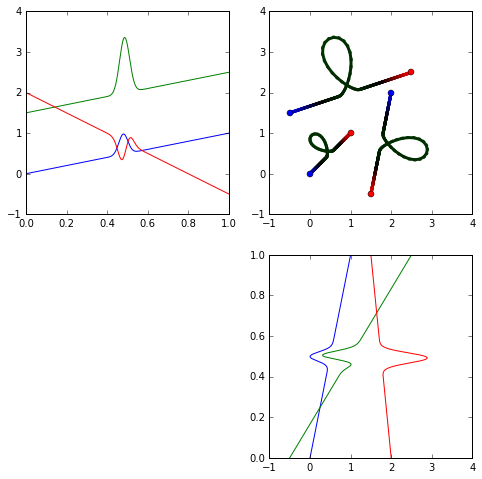

In [20]:
figure(figsize=(8,8))

plot_e([0,0],[1,1])
plot_e([-.5,1.5],[2.5,2.5])
plot_e([2,2],[1.5,-.5])


### Trajectories
Below you can see the trajectories used in the simulations.
The *blue* ones are used for training, whilst the *red* ones are used for the generalization test.


done


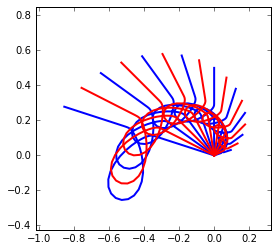

In [21]:
fig = figure()
ax = fig.add_subplot(111, aspect="equal")
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
    
for k in range(NY):
    plot(*Y[k].T, color="blue", lw=2)
for k in range(NT):
    plot(*T[k].T, color="red", lw=2)

print "done"

### Initialize the echo-state network

In [22]:
sim = ESN(
    N         = 3000,
    timesteps = TIMESTEPS,
    dt        = 0.001,
    tau       = 0.05,
    alpha     = 0.2,
    beta      = 0.8,
    epsilon   = 1.0e-60,
    lmbd      = 0.5e-3
)
print "done"

done


### Learning

Do the regression

In [23]:
# run the regression
sim.imitate_path(Y)
print "done"

done


### Test
Reproducing the trajectories

In [24]:
# reproduce the training trajectories
Y_r = []
for k in xrange(NY) :  
    y_r = sim.rollout(y0=start_Y[k], goal=goal_Y[k])
    Y_r.append(y_r.T)
    
# reproduce the test trajectories
T_r = []
for k in xrange(NT) :  
    t_r = sim.rollout(y0=start_T[k], goal=goal_T[k])
    T_r.append(t_r.T)
print "done"

done


Computing the errors

In [25]:
Y_rmse = rmse ( array(Y).ravel(), array(Y_r).ravel())
T_rmse = rmse ( array(T).ravel(), array(T_r).ravel())
print "       TRAINING RMSE: {}".format( Y_rmse )
print " GENERALIZATION RMSE: {}".format( T_rmse )


       TRAINING RMSE: 0.00331926276106
 GENERALIZATION RMSE: 0.0046154646694


### Plots
Plotting the trajectories

done


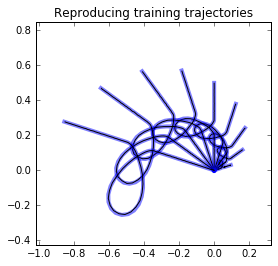

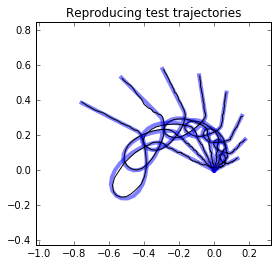

In [26]:
fig = figure()
ax = fig.add_subplot(111, aspect="equal")
ax.set_title("Reproducing training trajectories")
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
    
for k in range(NY):
    plot(*Y[k].T, color="blue", lw=4, alpha=.5)
    plot(*Y_r[k].T, color="black", lw=1)

fig = figure()
ax = fig.add_subplot(111, aspect="equal")
ax.set_title("Reproducing test trajectories")
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
    
for k in range(NT):
    plot(*T[k].T, color="blue", lw=4, alpha=.5)
    plot(*T_r[k].T, color="black", lw=1)
    
print "done"

Plotting the activity and the spectrogram of the network

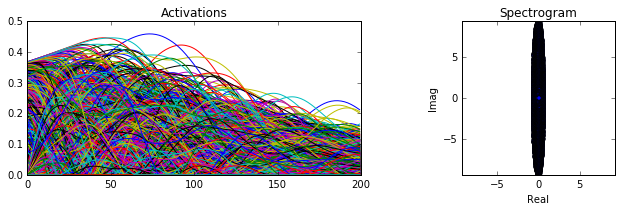

In [27]:
# activity
fig = figure(figsize=(10,3))
ax = fig.add_subplot(121)
ax.set_title("Activations")
x = sim.activations()
pl = ax.plot(x.T)

#spectrogram
ax = fig.add_subplot(122, aspect="equal")
ax.set_title("Spectrogram")
l = eigvals(sim.res.w)
sr = max(abs(l))
sc = ax.scatter(real(l), imag(l))
ax.set_xlim([-sr,sr])
ax.set_ylim([-sr,sr])
ax.set_xlabel("Real")
ax.set_ylabel("Imag")

tight_layout()